<a href="https://colab.research.google.com/github/fagonzalezo/qmc/blob/master/examples/qmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

In [2]:
%matplotlib inline
import numpy as np
import pylab as pl

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=0.3)
    pl.colorbar()
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import qmc.tf.layers as layers
import qmc.tf.models as models



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

63/63 [==============================] - 0s 843us/step
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  P

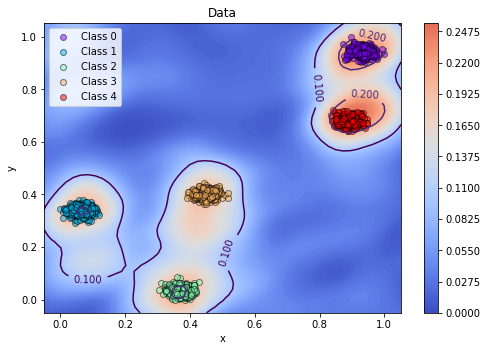

In [4]:
X, y = make_blobs(n_samples=2000, n_features=2, centers=5, cluster_std=0.2, random_state=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
fm_x = layers.QFeatureMapRFF(2, dim=40, gamma=25, random_state=17)
qmd = models.QMDensity(fm_x)
out = qmd(X[:2,:])
qmd.compile()
qmd.fit(X, epochs=1)
out = qmd.predict(X)
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, qmd.predict)
plot_data(X, y)

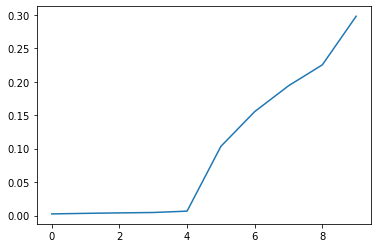

In [7]:
pl.plot(eig_vals[-10:])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0.0011275304 0.0011275304


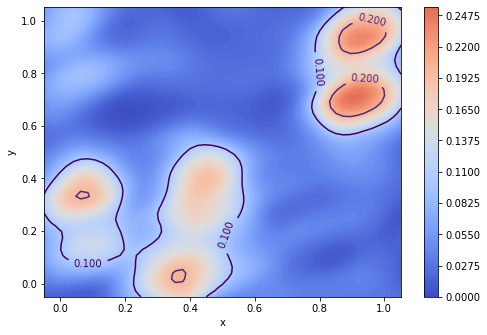

In [5]:
qmd1 = models.QMDensitySGD(2, 40, num_eig= 5, gamma=25, random_state=17)
out = qmd1(X[:2,:])
eig_vals = qmd1.set_rho(qmd.weights[2])
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, qmd1.predict)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1.3542647e-09 1.3542647e-09


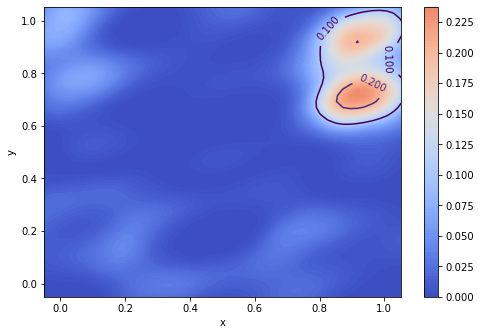

In [6]:
idx = 4
eig_vec = qmd1.weights[2][:,idx:idx+1]
rho = tf.matmul(eig_vec, tf.transpose(eig_vec, conjugate=True))
qmd2 = models.QMDensitySGD(2, 40, num_eig= 1, gamma=25, random_state=17)
out = qmd2(X[:2,:])
qmd2.set_rho(rho)
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, qmd2.predict)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
qmd3 = models.QMDensitySGD(2, 40, num_eig= 5, gamma=25, random_state=17)
out = qmd3(X[:2,:])
qmd3.compile(optimizer)
#qmc1.set_rho(qmc.weights[2])
qmd3.fit(X, epochs=1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

63/63 [==============================] - 0s 3ms/step - loss: -260.4821
